In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [13]:
import os
import subprocess
import pickle as pkl

import torch
import numpy as np
from matplotlib import pyplot as plt

from mtt.data import OnlineDataset
from mtt.models import load_model, Conv2dCoder
from mtt.peaks import find_peaks
from mtt.utils import ospa, gaussian, make_grid
from mtt.simulator import Simulator
from mtt.phd import phd_filter, positions_from_phd

rng = np.random.default_rng()

In [28]:
scale = 2

def init_simulator():
    return Simulator(window=1000 * scale)

online_dataset = OnlineDataset(n_steps=119, sigma_position=10, length=20, img_size=scale * 128, device="cuda", init_simulator=init_simulator)
with open(f"../data/test/{scale}km/simulations.pkl", "rb") as f: 
    dataset_vectors = pkl.load(f)
    
dataset_idx = 1
images = map(online_dataset.vectors_to_images, *zip(*dataset_vectors[dataset_idx]))
stacked = list(online_dataset.stack_images(images))

In [29]:
simulator = dataset_vectors[0][0][4]
window = simulator.window
extent = [-window/2, window/2, -window/2, window/2]
n_detections = simulator.n_sensors * np.pi * simulator.sensors[0].range_max ** 2 / 1000 ** 2

In [14]:
# load model
model = load_model(Conv2dCoder, "58c6fd8a")

In [15]:
x = torch.stack([d[0] for d in stacked], dim=0)
with torch.no_grad():
    pred_img = model(x.cuda()).cpu().numpy()

n = pred_img.shape[0]
filt_idx = -1

width = online_dataset.init_simulator().width
window = online_dataset.init_simulator().window
extent = [-window / 2, window / 2, -window / 2, window / 2]

predictions_cnn = []
for i in range(n):
    predictions_cnn.append(find_peaks(pred_img[i][filt_idx], width=window)[0])

In [ ]:
# with open("../data/test/phd.pkl", "rb") as f:
#     dataset_phd = pkl.load(f)
# phd = dataset_phd[dataset_idx][online_dataset.length-1:]
# predictions_phd = []
# for i in range(n):
#     predictions_phd.append(positions_from_phd(phd[i], n_detections))

ValueError: too many values to unpack (expected 2)

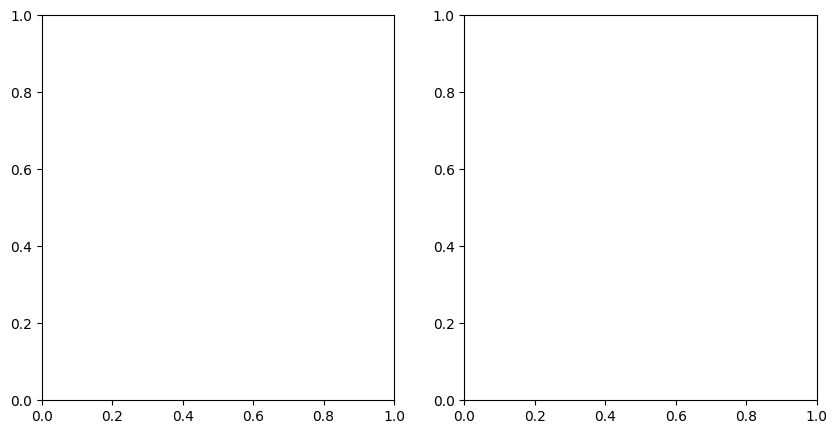

In [16]:
from mtt.peaks import sample_image, fit_gmm
from mtt.utils import gaussian
from matplotlib.patches import Ellipse
from matplotlib import transforms

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

idx = 60

target_pos = stacked[idx][2][filt_idx]["target_positions"]
mus, covs = find_peaks(pred_img[idx][filt_idx], width=window)

axs[0].imshow(stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower")
axs[1].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower")
for ax in axs:
    ax.scatter(*target_pos.T, c="w", s=10)
    ax.scatter(*mus.T, c="r", s=10)
    ax.set_xlim(-window / 2, window / 2)
    ax.set_ylim(-window / 2, window / 2)
plt.show()

In [ ]:
card_true = np.array([len(d[2][filt_idx]["target_positions"]) for d in stacked])
card_cnn = np.array([len(p) for p in predictions_cnn])
card_phd = np.array([len(p) for p in predictions_phd])

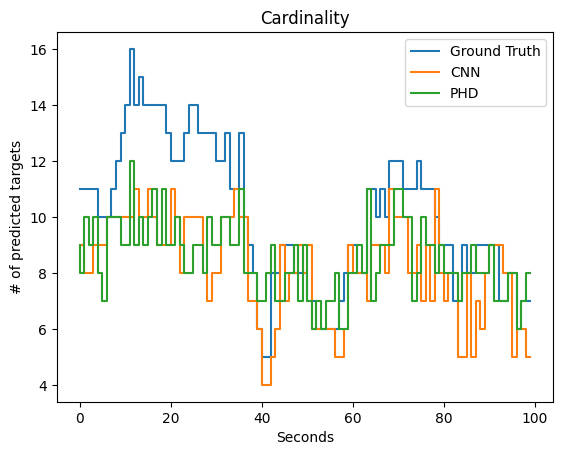

In [ ]:
# plot cardinality
plt.title("Cardinality")
plt.step(np.arange(n), card_true, label="Ground Truth")
plt.step(np.arange(n), card_cnn, label="CNN")
plt.step(np.arange(n), card_phd, label="PHD")
plt.xlabel("Seconds")
plt.ylabel("# of predicted targets")
plt.legend()
plt.savefig("../figures/cardinality.png")

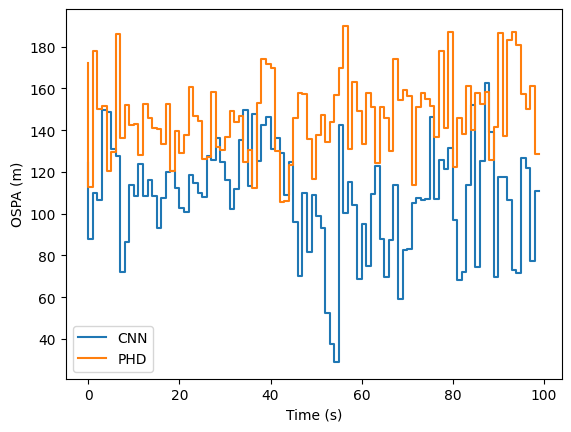

In [ ]:
ospa_cnn = []
ospa_phd = []
for idx in range(n):
    sensor_img, target_img, info = stacked[idx]
    target_positions = info[-1]["target_positions"]
    ospa_cnn += [ospa(target_positions, predictions_cnn[idx], 200)]
    ospa_phd += [ospa(target_positions, predictions_phd[idx], 200)]

plt.figure()
plt.step(np.arange(n), ospa_cnn, label="CNN")
plt.step(np.arange(n), ospa_phd, label="PHD")
plt.ylabel("OSPA (m)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../figures/ospa.png")